# Homework 2 - Data Science with CO2

__Hand-in__:

- __Due: 07.04.2020 23:59 CET__
- `git push` your final verion to your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your codes readable

## Description of the project:

   In this assignment, we will curate a set of **CO2 measurements**, measured from cheap but inaccurate sensors, that have been deployed in the city of Zurich. The goal of the exercise is twofold: 

1. Learn how to deal with real world sensor timeseries data, and organize them efficiently using python dataframes.

2. Apply data science tools to model the measurements, and use the learned model to process them (e.g., detect outliers and drifts in the sensor measurements). 

The sensor network consists of 46 sites, located in different parts of the city. Each site contains three different sensors measuring (a) **CO2 concentration**, (b) **temperature**, and (c) **humidity**. Beside these measurements, we have the following additional information that can be used to process the measurements: 

1. The **altitude** at which the CO2 sensor is located, and the GPS coordinates (latitude, longitude).

2. A clustering of the city of Zurich in 17 different city zones and the **zone** in which the sensor belongs to. Some characteristic zones are industrial area, residential area, forest, glacier, lake, etc.

Given this knowledge, you are asked to define an algorithm that curates the data, by detecting and removing potential drifts. The algorithm should be based on the fact that sensors in similar conditions are expected to have similar measurements. 

## Prior knowledge:
    
The average value of the CO2 in a city is approximately 400 ppm. However, the exact measurement in each site depends on parameters such as the temperature, the humidity, the altitude, and the level of traffic around the site. For example, sensors positioned in high altitude (mountains) and exposed to stronger winds, are expected to have a much lower and uniform level of CO2 than sensors that are positioned in a business area with much higher traffic activity. Moreover, we know that there is a strong dependence of the CO2 measurements on temperature and humidity.


### To start with: 

#### The following csv files will be needed which can be found in the `../data/` folder: 

1. `CO2_sensor_measurements.csv`
    
   __Description__: It containts the CO2 measurements (CO2), the name of the site (LocationName), a unique sensor identifier (SensorUnit_ID), and the time instance in which the measurement was taken (timestamp).
    
2. `temperature_humidity.csv`

   __Description__: It contains the temperature and the humidity measurements for each sensor identifier, at each timestamp (Timestamp). For each SensorUnit_ID, the temperature and the humidity can be found in the corresponding columns of the dataframe (SensorUnit_ID.temperature, SensorUnit_ID.humidity).
    
3. `sensor_metadata_updated.csv`

   __Description__: It contains the name of the site (LocationName), the zone index (zone), the altitude in meters, and longitude, latitude. 

Import the following python packages:

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import statsmodels.api as sm
import array
import os
from datetime import date
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### PART I: Handling time series with pandas (10 points)

a) **8/10** Merge the `CO2_sensor_measurements.csv`, `temperature_humidity.csv`, and `sensors_metadata.csv`, into a single dataframe like this:

| timestamp | LocationName | SensorUnit_ID | CO2 | temperature | humidity | zone | altitude | lon | lat |
|:---------:|:------------:|:-------------:|:---:|:-----------:|:--------:|:----:|:--------:|:---:|:---:|
|    ...    |      ...     |      ...      | ... |     ...     |    ...   |  ... |    ...   | ... | ... |

The merged dataframe contains as index the time instance (timestamp) of the measurements, and columns the location of the site (LocationName), the sensor ID (SensorUnit_ID), the CO2 measurement, the temperature, the humidity, the zone, the altitude, the longitude and the latitude. For each measurement, take the average over an interval of 30 min. If there are missing measurements, interpolate them linearly from measurements that are close by in time.

__Hints__: The following methods could be useful

1. ```python 
pandas.DataFrame.resample()
``` 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
    
2. ```python
pandas.DataFrame.interpolate()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
    
3. ```python
pandas.DataFrame.mean()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html
    
4. ```python
pandas.DataFrame.append()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html

In [2]:
measurements = pd.read_csv("../data/CO2_sensor_measurements.csv", sep="\t", parse_dates=["timestamp"])
temperature_humidity = pd.read_csv("../data/temperature_humidity.csv", sep="\t", parse_dates=["Timestamp"])
metadata = pd.read_csv("../data/sensors_metadata_updated.csv", sep=",", index_col = 0)

# We group all the "constant" information about the sensors to make the final merge easier
metadata_id = pd.merge(metadata, measurements[["LocationName", "SensorUnit_ID"]].drop_duplicates(), on="LocationName")
metadata_id.head()

,LocationName,zone,altitude,LAT,LON,X,Y,SensorUnit_ID
0,AJGR,2,627.8,47.33321,8.480300,243005.0,678731.4,1122
1,BSCR,2,462.3,47.35581,8.430070,245468.0,674903.4,1120
2,BUDF,10,490.2,47.36270,8.433110,246237.5,675123.8,1124
3,KBRL,7,510.5,47.32582,8.537550,242242.3,683070.1,1176
4,KTGM,2,530.3,47.32334,8.596422,242031.0,687523.9,1211


### Measurements

In [3]:
# We begin by resampling the measurements
measurements.head()

,timestamp,LocationName,SensorUnit_ID,CO2
0,2017-10-01 00:05:00,ZGHD,1014,593.321562
1,2017-10-01 00:15:00,ZGHD,1014,595.846258
2,2017-10-01 00:25:00,ZGHD,1014,595.845353
3,2017-10-01 00:45:00,ZGHD,1014,599.039129
4,2017-10-01 00:55:00,ZGHD,1014,594.996629


In [4]:
measurements.isna().any()

timestamp        False
LocationName     False
SensorUnit_ID    False
CO2              False
dtype: bool

In [5]:
sample_measurement = pd.DataFrame()

for sensorid in measurements["SensorUnit_ID"].unique():
    
    #construct a time-series of the co2_mesures for the sensorsid
    co2_mesures = measurements.loc[measurements["SensorUnit_ID"]==sensorid, ["timestamp", "CO2"]].set_index("timestamp", drop=True)
    
    #upsample the series into 30 minute bins and take the average
    co2_mesures = co2_mesures.resample("30T").mean()
    co2_mesures["SensorUnit_ID"] = sensorid
    
    #interpolate the missing values linearly 
    co2_mesures = co2_mesures.interpolate(method="linear",direction="both")
    sample_measurement = sample_measurement.append(co2_mesures)
    
sample_measurement = sample_measurement.rename_axis('timestamp').reset_index()
sample_measurement.head()

,timestamp,CO2,SensorUnit_ID
0,2017-10-01 00:00:00,595.004391,1014
1,2017-10-01 00:30:00,597.017879,1014
2,2017-10-01 01:00:00,596.487010,1014
3,2017-10-01 01:30:00,598.787639,1014
4,2017-10-01 02:00:00,595.366394,1014


In [6]:
measurements_metadata = pd.merge(sample_measurement, metadata_id, how="left", on="SensorUnit_ID")  

In [7]:
measurements_metadata.set_index('timestamp',inplace = True, drop = True)
measurements_metadata.head()

,CO2,SensorUnit_ID,LocationName,zone,altitude,LAT,LON,X,Y
timestamp,,,,,,,,,
2017-10-01 00:00:00,595.004391,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0
2017-10-01 00:30:00,597.017879,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0
2017-10-01 01:00:00,596.487010,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0
2017-10-01 01:30:00,598.787639,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0
2017-10-01 02:00:00,595.366394,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0


### Temperature & Humidity

In [8]:
temperature_humidity.head()

,Timestamp,1014.temperature,1014.humidity,1015.temperature,1015.humidity,1016.temperature,1016.humidity,1017.temperature,1017.humidity,1018.temperature,...,1291.temperature,1291.humidity,1292.temperature,1292.humidity,1297.temperature,1297.humidity,1298.temperature,1298.humidity,1299.temperature,1299.humidity
0,2017-10-01 00:00:00,11.39,92.262787,10.55,91.949982,11.02,92.613739,11.05,89.811844,11.38,...,10.13,96.828979,10.50,95.858139,10.70,94.524902,11.35,90.288681,11.44,90.118927
1,2017-10-01 00:10:00,11.39,92.579407,10.48,92.079681,11.04,93.063873,11.05,90.042633,11.38,...,10.12,97.322983,10.45,95.903915,10.53,94.395203,11.35,90.422195,11.46,90.073151
2,2017-10-01 00:20:00,11.41,92.480225,10.51,92.583221,11.06,93.201202,11.02,89.888138,11.35,...,10.14,97.780746,10.43,95.343155,10.45,94.620270,11.33,91.023010,11.41,89.466614
3,2017-10-01 00:30:00,11.35,91.902298,10.55,92.714828,11.02,92.932266,10.96,89.790863,11.31,...,10.13,97.904724,10.43,95.322174,10.42,94.973129,11.32,91.019196,11.39,89.249176
4,2017-10-01 00:40:00,11.30,91.639084,10.59,92.764420,10.99,92.598480,10.95,89.821381,11.27,...,10.13,97.931427,10.48,96.451324,10.46,95.282120,11.28,90.443176,11.31,88.871521


In [9]:
temperature_humidity.set_index('Timestamp',inplace =True )

In [10]:
temperature_humidity.columns = temperature_humidity.columns.str.split('.', expand=True)
temperature_humidity.head()

1014                   1015                   1016  \
                    temperature   humidity temperature   humidity temperature   
Timestamp                                                                       
2017-10-01 00:00:00       11.39  92.262787       10.55  91.949982       11.02   
2017-10-01 00:10:00       11.39  92.579407       10.48  92.079681       11.04   
2017-10-01 00:20:00       11.41  92.480225       10.51  92.583221       11.06   
2017-10-01 00:30:00       11.35  91.902298       10.55  92.714828       11.02   
2017-10-01 00:40:00       11.30  91.639084       10.59  92.764420       10.99   

                                      1017                   1018             \
                      humidity temperature   humidity temperature   humidity   
Timestamp                                                                      
2017-10-01 00:00:00  92.613739       11.05  89.811844       11.38  91.427368   
2017-10-01 00:10:00  93.063873       11.05  90.042633       11.38  91.240448   
2017-10-01 00:20:00  93.201202       11.02  89.888138       11.35  90.511841   
2017-10-01 00:30:00  92.932266       10.96  89.790863       11.31  90.481323   
2017-10-01 00:40:00  92.598480       10.95  89.821381       11.27  89.668793   

                     ...        1291                   1292             \
                     ... temperature   humidity temperature   humidity   
Timestamp            ...                                                 
2017-10-01 00:00:00  ...       10.13  96.828979       10.50  95.858139   
2017-10-01 00:10:00  ...       10.12  97.322983       10.45  95.903915   
2017-10-01 00:20:00  ...       10.14  97.780746       10.43  95.343155   
2017-10-01 00:30:00  ...       10.13  97.904724       10.43  95.322174   
2017-10-01 00:40:00  ...       10.13  97.931427       10.48  96.451324   

                           1297                   1298                   1299  \
                    temperature   humidity temperature   humidity temperature   
Timestamp                                                                       
2017-10-01 00:00:00       10.70  94.524902       11.35  90.288681       11.44   
2017-10-01 00:10:00       10.53  94.395203       11.35  90.422195       11.46   
2017-10-01 00:20:00       10.45  94.620270       11.33  91.023010       11.41   
2017-10-01 00:30:00       10.42  94.973129       11.32  91.019196       11.39   
2017-10-01 00:40:00       10.46  95.282120       11.28  90.443176       11.31   

                                
                      humidity  
Timestamp                       
2017-10-01 00:00:00  90.118927  
2017-10-01 00:10:00  90.073151  
2017-10-01 00:20:00  89.466614  
2017-10-01 00:30:00  89.249176  
2017-10-01 00:40:00  88.871521  

[5 rows x 92 columns]

In [11]:
temp_hum_sensor = pd.DataFrame(columns = ["temperature","humidity","SensorUnit_ID"])

for sensorid in temperature_humidity.columns.get_level_values(0).drop_duplicates():
    
    #select the time-series of the temperature and humudity mesures for the sensorsid
    temperature_humidity_mesures = temperature_humidity[sensorid]
    
    #upsample the series into 30 minute bins and take the average
    temperature_humidity_mesures = temperature_humidity_mesures.resample("30T").mean()
    temperature_humidity_mesures["SensorUnit_ID"]= int(sensorid)
    
    #interpolate the missing values linearly 
    temperature_humidity_mesures = temperature_humidity_mesures.interpolate(method="linear",direction="both")
    
    temp_hum_sensor = temp_hum_sensor.append(temperature_humidity_mesures)

temp_hum_sensor.index.name = 'timestamp'
temp_hum_sensor.head()

,temperature,humidity,SensorUnit_ID
timestamp,,,
2017-10-01 00:00:00,11.396667,92.440806,1014
2017-10-01 00:30:00,11.325000,91.770691,1014
2017-10-01 01:00:00,11.240000,91.096761,1014
2017-10-01 01:30:00,11.260000,91.275734,1014
2017-10-01 02:00:00,11.290000,91.061157,1014


In [12]:
temp_hum_sensor.isna().any()

temperature      False
humidity         False
SensorUnit_ID    False
dtype: bool

In [13]:
meta_temp_hum = pd.merge(temp_hum_sensor, metadata_id, right_index =True, on="SensorUnit_ID")  
meta_temp_hum.head()

,temperature,humidity,SensorUnit_ID,LocationName,zone,altitude,LAT,LON,X,Y
timestamp,,,,,,,,,,
2017-10-01 00:00:00,11.396667,92.440806,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0
2017-10-01 00:30:00,11.325000,91.770691,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0
2017-10-01 01:00:00,11.240000,91.096761,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0
2017-10-01 01:30:00,11.260000,91.275734,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0
2017-10-01 02:00:00,11.290000,91.061157,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0


In [14]:
common = ["timestamp", "SensorUnit_ID", "LAT", "LON", "altitude","zone", "LocationName","X","Y"]
final = pd.merge(meta_temp_hum, measurements_metadata, on = common , how="outer")
final.head()

,temperature,humidity,SensorUnit_ID,LocationName,zone,altitude,LAT,LON,X,Y,CO2
timestamp,,,,,,,,,,,
2017-10-01 00:00:00,11.396667,92.440806,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0,595.004391
2017-10-01 00:30:00,11.325000,91.770691,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0,597.017879
2017-10-01 01:00:00,11.240000,91.096761,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0,596.487010
2017-10-01 01:30:00,11.260000,91.275734,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0,598.787639
2017-10-01 02:00:00,11.290000,91.061157,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0,595.366394


In [15]:
final.isna().any()

temperature      False
humidity         False
SensorUnit_ID    False
LocationName     False
zone             False
altitude         False
LAT              False
LON              False
X                False
Y                False
CO2               True
dtype: bool

In [16]:
final[final['CO2'].isna()]

,temperature,humidity,SensorUnit_ID,LocationName,zone,altitude,LAT,LON,X,Y,CO2
timestamp,,,,,,,,,,,
2017-10-01 00:00:00,11.325000,93.023819,1117,ZHRO,2,397.6,47.393940,8.486670,249762.8,679123.2,NaN
2017-10-01 00:30:00,11.253333,91.347260,1117,ZHRO,2,397.6,47.393940,8.486670,249762.8,679123.2,NaN
2017-10-01 01:00:00,11.165000,91.319603,1117,ZHRO,2,397.6,47.393940,8.486670,249762.8,679123.2,NaN
2017-10-01 01:30:00,11.135000,91.498894,1117,ZHRO,2,397.6,47.393940,8.486670,249762.8,679123.2,NaN
2017-10-01 02:00:00,11.216667,91.673416,1117,ZHRO,2,397.6,47.393940,8.486670,249762.8,679123.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2017-10-19 10:30:00,14.856667,67.263804,1174,ZPFW,1,402.5,47.388045,8.513577,249135.5,681163.0,NaN
2017-10-19 11:00:00,15.863333,65.317673,1174,ZPFW,1,402.5,47.388045,8.513577,249135.5,681163.0,NaN
2017-10-19 11:30:00,20.733333,57.518524,1174,ZPFW,1,402.5,47.388045,8.513577,249135.5,681163.0,NaN


**We still have 2 stations that have Nan values.**

In [17]:
measurements[measurements['LocationName'] == 'ZHRO'].timestamp

100100   2017-10-19 13:44:00
100101   2017-10-19 13:54:00
100102   2017-10-19 14:04:00
100103   2017-10-19 14:14:00
100104   2017-10-19 14:24:00
                 ...        
101686   2017-10-31 23:04:00
101687   2017-10-31 23:24:00
101688   2017-10-31 23:34:00
101689   2017-10-31 23:44:00
101690   2017-10-31 23:54:00
Name: timestamp, Length: 1591, dtype: datetime64[ns]

**It appears that for 2 sensors we do not have measurements for the beginning of October. In order to have consistent data for all the stations and for the entire month we decide to drop the 2 stations.**

In [18]:
final.dropna(inplace= True)

b) **2/10** Export the curated and ready to use timeseries to a csv file. 

In [19]:
final.to_csv("../data/final.csv", index=True)

### PART II: Data visualization (15 points)

a) **5/15** Group the sites based on their altitude, by performing K-means clustering. Find the optimal number of clusters using the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). Write out the formula of metric you intend to use for Elbow curve. Add an additional column to the dataframe of the previous question indicating the altitude cluster index. 

__Note__: [Yellowbrick](http://www.scikit-yb.org/) is a very nice Machine Learning Visualization extension to scikit-learn, which might be useful to you. 

In [20]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

**We would like to group  the sites based on their altitude.**

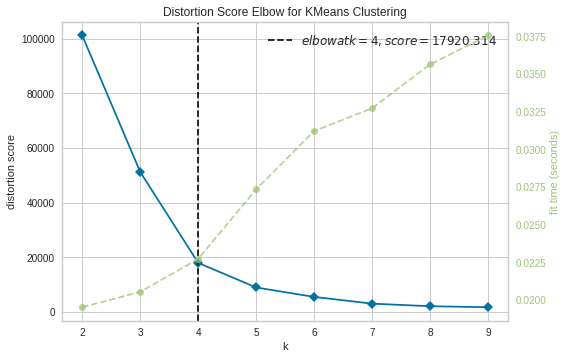

In [21]:
model = KMeans()

visualizer = KElbowVisualizer(model, k= (2, 10), metric='distortion')
visualizer.fit(final["altitude"].unique().reshape(-1,1))        
visualizer.show()
plt.show()

**The chosen metric was `distortion`, which computes the sum of squared distances (SSE) from each point to its assigned center corresponding to the Euclidian distance. We chose a maximum number of clusters of 10 because it firstly avoids overfitting, but also doesn’t seem reasonable to have much more clusters than that with the data we have.**

**As we can see, the numbers of cluster given by the elbow method is 4.**

In [22]:
# KMeans algorithm with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0).fit(final["altitude"].unique().reshape(-1,1))
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       3, 3, 0, 1, 3, 0, 1, 3, 0, 0, 3, 0, 0, 0, 3, 0, 2, 1, 0, 3, 0, 0,
       0, 0], dtype=int32)

In [23]:
# New column "Cluster" to show the cluster to which the location belongs to
i = 0
for alt in final["altitude"].unique():
    final.loc[final["altitude"]==alt, "Cluster"] = kmeans.labels_[i]
    i +=1
    
final.head()

,temperature,humidity,SensorUnit_ID,LocationName,zone,altitude,LAT,LON,X,Y,CO2,Cluster
timestamp,,,,,,,,,,,,
2017-10-01 00:00:00,11.396667,92.440806,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0,595.004391,0.0
2017-10-01 00:30:00,11.325000,91.770691,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0,597.017879,0.0
2017-10-01 01:00:00,11.240000,91.096761,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0,596.487010,0.0
2017-10-01 01:30:00,11.260000,91.275734,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0,598.787639,0.0
2017-10-01 02:00:00,11.290000,91.061157,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0,595.366394,0.0


b) **3/15** Plot the monthly median CO2 measurement for each site with respect to the altitude. Annotate each point of the plot with the name of the location (LocatioName), and give the same color to stations that belong to the same altitude  cluster.    

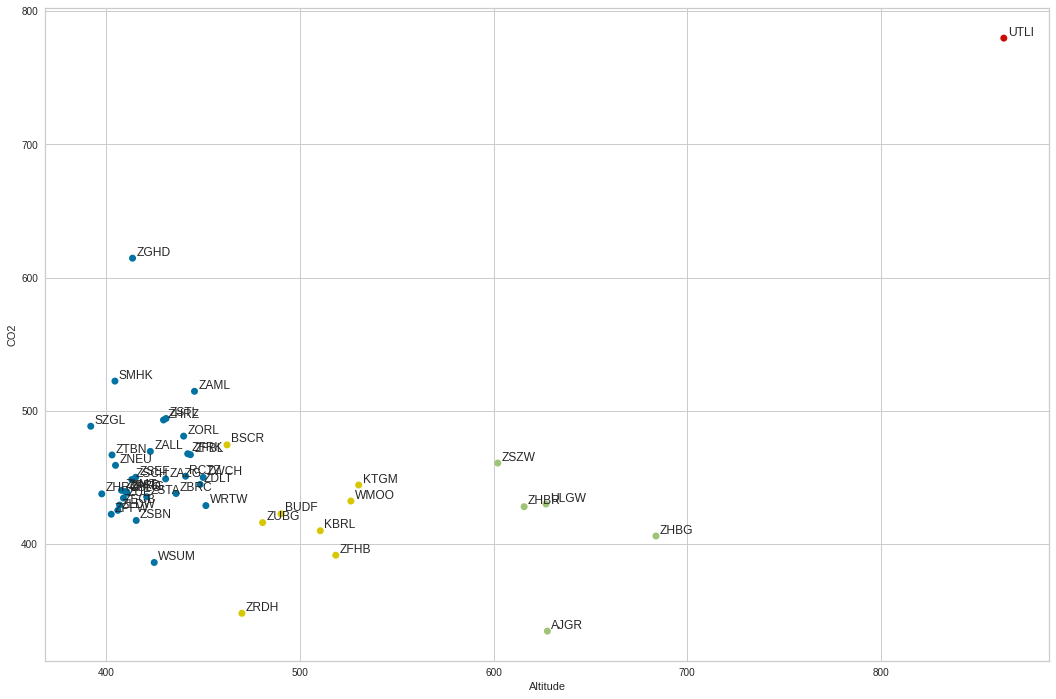

In [24]:
color = ['b', 'g', 'r', 'y']
label_color = [color[int(l)] for l in final.groupby(["LocationName"]).median()["Cluster"]]

fig, ax = plt.subplots(figsize=(18,12))
x, y = final.groupby(["LocationName"]).median()["altitude"], final.groupby(["LocationName"]).median()["CO2"]
ax.scatter(x, y, c=label_color, edgecolors='none')
ax.grid(True)

for i, txt in enumerate(final.groupby(["LocationName"]).median().index):
    ax.annotate(txt, (x[i]+2, y[i]+2))
plt.xlabel("Altitude")
plt.ylabel("CO2")
plt.show()

**There seems to be a trend here: the lower the altitude, the higher the CO2 measurements. It is actually a logical result since being lower in altitude corresponds to being closer to the city where the CO2 emission is higher.**

**Let's note that there clearly is an outlier which is UTLI, with the highest altitude but also the highest CO2 measurements. After having a look at its location, we noted that it is very close to a highway, which may explain these results.**

c) **7/15** Plot the stations on an interactive Zurich map, and dispay their location name. And, on the same map, plot a time-varying heatmap of the mean daily CO2 concentration for all the stations.

__Note__: You can use the python library [Folium](https://python-visualization.github.io/folium/) for that, but any other visualization tools can be used.

In [25]:
import folium
from folium import plugins

In [26]:
# Dataframe with location name and coordinates
positions = final.drop_duplicates(subset=['LocationName','LAT','LON'])[['LocationName', 'LAT', 'LON']].reset_index(drop=True)
positions.head()

,LocationName,LAT,LON
0,ZGHD,47.370446,8.523256
1,ZORL,47.414780,8.537913
2,ZTBN,47.389721,8.517753
3,ZHRG,47.377773,8.519460
4,ZSCH,47.370983,8.523569


In [27]:
# Dataframe with the information used for the map: mean of the CO2 emission per timestamp,
# with the corresponding location name and coordinates
co2_time = final[['LocationName', 'LAT', 'LON', 'CO2']]
co2_time = co2_time.groupby('LocationName').resample('1D').mean().reset_index(level = 0)
co2_time.head()

,LocationName,LAT,LON,CO2
timestamp,,,,
2017-10-01,AJGR,47.33321,8.4803,336.656408
2017-10-02,AJGR,47.33321,8.4803,342.793705
2017-10-03,AJGR,47.33321,8.4803,335.531220
2017-10-04,AJGR,47.33321,8.4803,335.316507
2017-10-05,AJGR,47.33321,8.4803,340.486617


In [28]:
m = folium.Map(location=[47.374876, 8.538429],  tiles='stamentoner', zoom_start = 10.4) 

In [29]:
# Rescale the mesurements in [0, 1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
co2_time['CO2_scaled'] = scaler.fit_transform(co2_time[['CO2']])

In [30]:
heat_data = [ [ [row['LAT'], row['LON'], row['CO2_scaled'] ]
                for index, row in co2_time[i == co2_time.index].iterrows()] 
                for i in co2_time.index.unique()] 

In [31]:
hm = plugins.HeatMapWithTime(heat_data, radius=20 , auto_play=True, gradient={0.1: 'blue', 0.2: 'lime', 0.4 : 'orange', 0.7: 'red'}, min_opacity=0.5, max_opacity=0.8)
hm.add_to(m)

for index,point in positions.iterrows() :
    folium.CircleMarker(location= [point.LAT,point.LON], popup=point.LocationName,radius=1, color='white').add_to(m)
m

**We can first see with this map that the highest concentrations of CO2 are the locations that are the closest to the city center, which corresponds to plot of the previous question (b).**
**We can also observe evolutions during the month with some locations suddently having a much higher concentration for a specific day. This could be for example due to a higher traffic on that day.**

### PART III: Model fitting for data curation (35 points)

a) __3/35__ How to handle missing data matters in real-world data science project. Although here we have all the data, it is still a very good opportunity for you to learn. Let's assume there is one site `KBRL` which somehow lost all the CO2 data of `2017-10-04`. Compare different ways of interpolating for the missing values (in time: linear interpolation and cubic interpolation, in space: using other sensors in the same altitude cluster) and plot the interpolation results. Use the data you have as the ground truth to discuss your findings.

In [32]:
original_KBRL =  final[ final['LocationName'] == 'KBRL']

# Artificially set the values to NaN
data_missing = final.copy()
data_missing.reset_index(inplace=True)
data_missing.loc[(data_missing.timestamp.dt.day == 4) & (data_missing['LocationName'] == 'KBRL'),'CO2'] = np.nan

**Space interpolation:**

**We first check in which cluster the site is and we only keep the sites belonging to this cluster.**

In [33]:
cluster_kbrl = original_KBRL['Cluster'].values[0]
cluster_kbrl

3.0

In [34]:
#we select the data points that are in the same cluster
KBRL_space = data_missing[data_missing['Cluster'] == cluster_kbrl]
KBRL_space.head()

,timestamp,temperature,humidity,SensorUnit_ID,LocationName,zone,altitude,LAT,LON,X,Y,CO2,Cluster
11904,2017-10-01 00:00:00,10.290000,93.370321,1034,ZRDH,3,470.0,47.418554,8.511709,252525.1,680975.8,337.298130,3.0
11905,2017-10-01 00:30:00,10.336667,94.056966,1034,ZRDH,3,470.0,47.418554,8.511709,252525.1,680975.8,340.127627,3.0
11906,2017-10-01 01:00:00,10.353333,94.339254,1034,ZRDH,3,470.0,47.418554,8.511709,252525.1,680975.8,338.640770,3.0
11907,2017-10-01 01:30:00,10.293333,94.431442,1034,ZRDH,3,470.0,47.418554,8.511709,252525.1,680975.8,342.613645,3.0
11908,2017-10-01 02:00:00,10.246667,94.425720,1034,ZRDH,3,470.0,47.418554,8.511709,252525.1,680975.8,342.824630,3.0


In [35]:
# compute the means for sensors in the same cluster and for the same day 
cluster_co2 = KBRL_space[KBRL_space.timestamp.dt.day == 4].groupby("timestamp").CO2.mean()
cluster_co2.head()

timestamp
2017-10-04 00:00:00    415.658015
2017-10-04 00:30:00    419.320187
2017-10-04 01:00:00    419.600179
2017-10-04 01:30:00    422.086517
2017-10-04 02:00:00    421.699648
Name: CO2, dtype: float64

In [36]:
# find value of the rows for which we need to interpolate
nan_index = KBRL_space[KBRL_space["CO2"].isnull()].index
nan_timestamp = KBRL_space.loc[nan_index]["timestamp"]
KBRL_space.loc[nan_index].head()

,timestamp,temperature,humidity,SensorUnit_ID,LocationName,zone,altitude,LAT,LON,X,Y,CO2,Cluster
45979,2017-10-04 00:00:00,10.596667,76.635880,1176,KBRL,7,510.5,47.32582,8.53755,242242.3,683070.1,NaN,3.0
45980,2017-10-04 00:30:00,10.680000,76.431157,1176,KBRL,7,510.5,47.32582,8.53755,242242.3,683070.1,NaN,3.0
45981,2017-10-04 01:00:00,10.526667,77.201726,1176,KBRL,7,510.5,47.32582,8.53755,242242.3,683070.1,NaN,3.0
45982,2017-10-04 01:30:00,9.960000,77.628337,1176,KBRL,7,510.5,47.32582,8.53755,242242.3,683070.1,NaN,3.0
45983,2017-10-04 02:00:00,9.270000,80.417516,1176,KBRL,7,510.5,47.32582,8.53755,242242.3,683070.1,NaN,3.0


In [37]:
pd.options.mode.chained_assignment = None  # default='warn'
KBRL_space.loc[nan_index,"CO2"] = cluster_co2.values
KBRL_space_co2 = KBRL_space.loc[KBRL_space.LocationName == 'KBRL', ['timestamp','CO2']]
KBRL_space_co2.set_index("timestamp", inplace = True)

**Time interpolation:**

In [38]:
#select the KBRL data points and interpolate the missing C02 data 
KBRL_only = data_missing.loc[data_missing['LocationName'] == 'KBRL',['timestamp','CO2']].set_index('timestamp')
KBRL_linear_co2 = KBRL_only.interpolate(method="linear",direction="both")
KBRL_cubic_co2 = KBRL_only.interpolate(method="cubic",direction="both")

In [39]:
from datetime import date

original_KBRL_co2 = original_KBRL[['CO2']]
df_interpolation = pd.concat([original_KBRL_co2, KBRL_space_co2, KBRL_linear_co2, KBRL_cubic_co2], axis=1)
df_interpolation.columns = ['original data','space interpolation','linear interpolation','cubic interpolation']

index_day_missing = df_interpolation.index.to_series().dt.date.between(date(2017,10,4),date(2017,10,4))
df_interpolation[index_day_missing].head()

,original data,space interpolation,linear interpolation,cubic interpolation
timestamp,,,,
2017-10-04 00:00:00,401.702249,415.658015,405.897108,409.311843
2017-10-04 00:30:00,406.393932,419.320187,406.703494,413.786753
2017-10-04 01:00:00,406.798785,419.600179,407.509881,418.490169
2017-10-04 01:30:00,416.158277,422.086517,408.316267,423.396812
2017-10-04 02:00:00,422.556122,421.699648,409.122654,428.481401


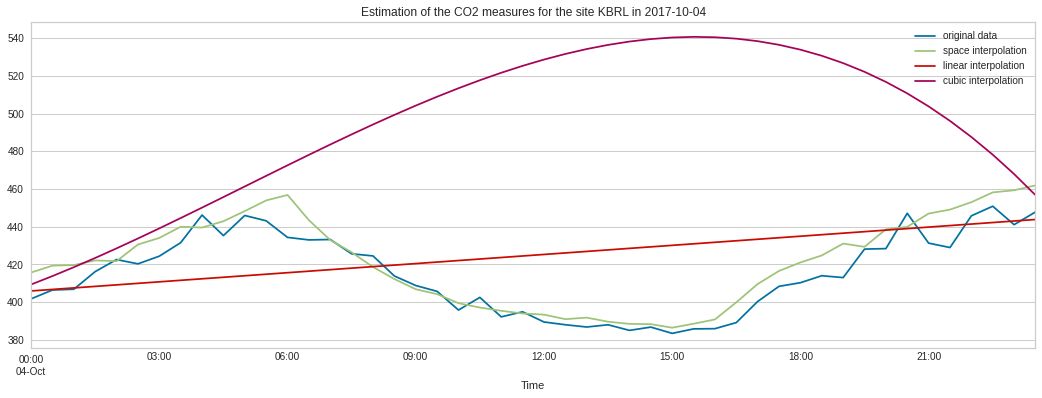

In [40]:
fig, ax = plt.subplots(figsize=(18,6))
df_interpolation[index_day_missing].plot(ax = ax)
plt.title("Estimation of the CO2 measures for the site KBRL in 2017-10-04")
plt.xlabel('Time')
plt.legend(loc='best')
plt.show()

**We observe that the best fit is the space interpolation which gives a very accurate estimation of the data. The linear interpolation is limited by its linearity and doesn't model the variations during the day, whereas the cubic interpolation has a poor estimation since it tends to overestimate the missing data.**  

b) **2/35** The technician in charge of these sensors reported that one of the CO2 sensors `ZSBN` is exhibiting a drift on Oct. 21. Verify the drift by visualizing the CO2 concentration of the drifting sensor and some other sensors from the network. 

**Knowing that sensors within the same cluster and same zone have very close measurements we will compare the ZSBN sensors data to those sensors before and after Oct. 21.**

In [41]:
nbr_cluster_zsbn = final[final.LocationName == 'ZSBN']['Cluster'].values[0]
zsbn_cluster = final[final.Cluster == nbr_cluster_zsbn].reset_index().copy()
zsbn_cluster.head()

,timestamp,temperature,humidity,SensorUnit_ID,LocationName,zone,altitude,LAT,LON,X,Y,CO2,Cluster
0,2017-10-01 00:00:00,11.396667,92.440806,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0,595.004391,0.0
1,2017-10-01 00:30:00,11.325000,91.770691,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0,597.017879,0.0
2,2017-10-01 01:00:00,11.240000,91.096761,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0,596.487010,0.0
3,2017-10-01 01:30:00,11.260000,91.275734,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0,598.787639,0.0
4,2017-10-01 02:00:00,11.290000,91.061157,1014,ZGHD,2,413.5,47.370446,8.523256,247188.9,681921.0,595.366394,0.0


In [42]:
zsbn_cluster.LocationName.unique()

array(['ZGHD', 'ZORL', 'ZTBN', 'ZHRG', 'ZSCH', 'ZUE', 'ZSBN', 'ZBLG',
       'ZFBL', 'ZSTL', 'ZECB', 'ZAML', 'ZHRZ', 'ZFRK', 'ZSTA', 'ZLMT',
       'ZNEU', 'ZPRD', 'ZBRC', 'ZHRO', 'ZDLT', 'ZPFW', 'WSUM', 'ZAZG',
       'ZWCH', 'SMHK', 'ZALL', 'SZGL', 'RCTZ', 'WRTW', 'ZSEF', 'ZLDW'],
      dtype=object)

In [43]:
zsbn_zone = zsbn_cluster[zsbn_cluster["LocationName"]=="ZSBN"]["zone"].values[0]
zsbn_cluster_zone = zsbn_cluster[zsbn_cluster.zone == zsbn_zone]

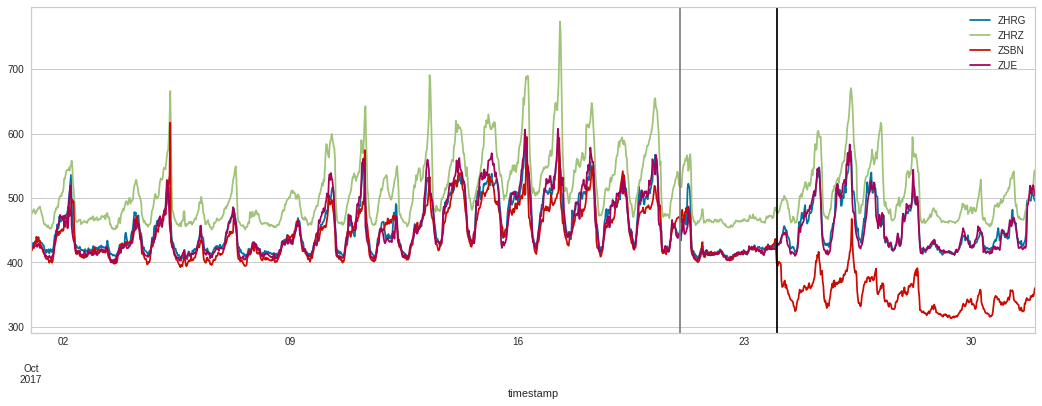

In [44]:
fig, ax = plt.subplots(figsize=(18,6))
for name, group in zsbn_cluster_zone.groupby('LocationName'):
    group.plot(x="timestamp", y='CO2', ax=ax, label=name)
plt.axvline(x="2017-10-24",color="black")
plt.axvline(x="2017-10-21",color="gray")
plt.show()

**We actually observe a drift but not in Oct 21 but rather in Octb 24. Indeed, before that date the 4 sensors have pretty similar trends but starting form Octb 24 we observe that the ZSBN sensor mesures are systematically smaller than the other sensors and with almost the same value (around 100).**

c) **6/35** We want to reconstruct the CO2 concentration of the drifting sensor had the drift not happened. Train a forecasting model on the CO2 values of the drifting sensor. Use linear regression with features the past CO2 values over an interval of 3 hours (past 6 observations), mathematically, $C_t \sim h(C_{t-1}, C_{t-2}, C_{t-3}, C_{t-4}, C_{t-5}, C_{t-6})$, where $C_i$ is the CO2 value at time $i$.

Plot and compare the actual CO2 measurements, and the values obtained by the prediction of the linear model for the entire month of October, together with their confidence interval obtained from cross validation. What do you observe? 

__Note__: 
1. Cross validation on time series is different from that on other kinds of datasets. scikit-learn provides a nice method for you, `sklearn.model_selection.TimeSeriesSplit`. For more on time series cross validation, there are a lot of interesting articles available online.
2. Think about how to make prediction on data before the drift and after the drift. What's the difference?

**Our goal is to reconstruct the CO2 concentration of the drifting without any drift. In order to do that we take as training data the the CO2 measures before the Oct 21.**

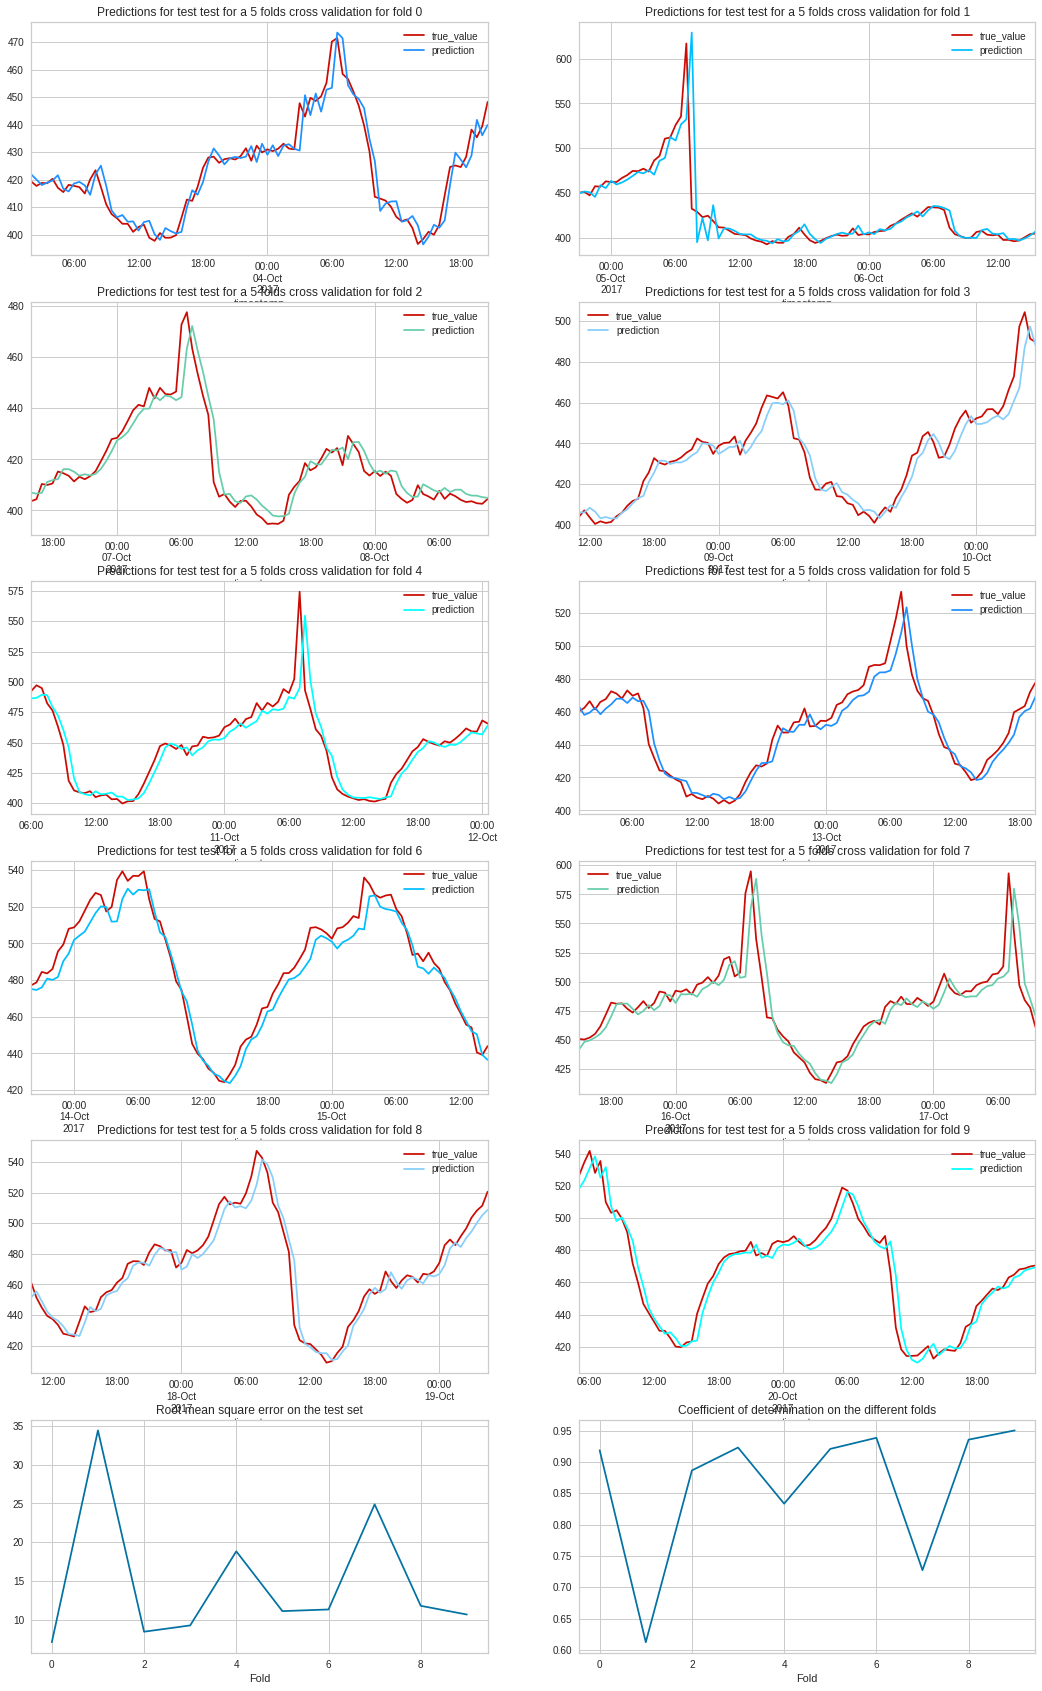

In [45]:
#For training data we only keep the data before Oct 21.,
zsbn = final[final.LocationName == 'ZSBN']
index_training_data = df_interpolation.index.to_series().dt.date.between(date(2017,10,1),date(2017,10,20))
training_set = zsbn[index_training_data].reset_index()

#the inputs are the dates and the output the C02 measures,
X = pd.DataFrame(training_set["timestamp"])
y = training_set["CO2"]

for i in range(1,7):
    X["lagged_{0}".format(i)] = y.shift(i)   # we construct Ct-1,..,Ct-6,

X.set_index("timestamp", inplace=True, drop =True )

#We drop the first six rows because we don't have all the 6 previous points,

X = X[6:]
y = y[6:]

index_training_data[:6] = False

#In the kth split, it returns first k folds as train set and the (k+1)th fold as test set,
K = 10
tscv = TimeSeriesSplit(K)
colors = ['dodgerblue', 'deepskyblue', 'mediumaquamarine','lightskyblue','cyan'] * 2
rmse = []
scores = []

# to plot what we obtain during the cross validation on the validation set
cv_pred = []
cv_true_pred = []
date_pred = []

fig, ax = plt.subplots(nrows=6, ncols=2,figsize=(18,30))
    
#Cross validation 
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lr = LinearRegression().fit(X_train,y_train)
    y_pred = lr.predict(X_test)

    cv_pred = [*cv_pred,*y_pred]
    date_pred = [*date_pred , *X_test.index]
    cv_true_pred = [*cv_true_pred, *y_test]

    scores.append( lr.score(X_test,y_test) )
    rmse.append( np.sqrt(2 *mean_squared_error(y_test, y_pred)) )

    pred_test = pd.DataFrame(index = X_test.index, data= {'true_value' : y_test.values,'prediction' : y_pred} )

    ix = np.unravel_index(i, ax.shape)
    pred_test.plot(color = ['r',colors[i]], ax=ax[ix])
    ax[ix].title.set_text('Predictions for test test for a 5 folds cross validation for fold {0}'.format(i))

ax[(5,0)].plot(rmse)
ax[(5,0)].title.set_text('Root mean square error on the test set')
ax[(5,1)].plot(scores)
ax[(5,0)].set_xlabel('Fold')
ax[(5,1)].title.set_text('Coefficient of determination on the different folds')
ax[(5,1)].set_xlabel('Fold')
plt.show()

**From the root mean square errors we construct a 95% confidence interval**

In [46]:
scale = 1.96
mean_rmse = np.mean(rmse)
std_rmse = np.std(rmse)

margin = mean_rmse + scale * std_rmse
lower = cv_pred - margin
upper = cv_pred + margin

margin

30.986645099207855

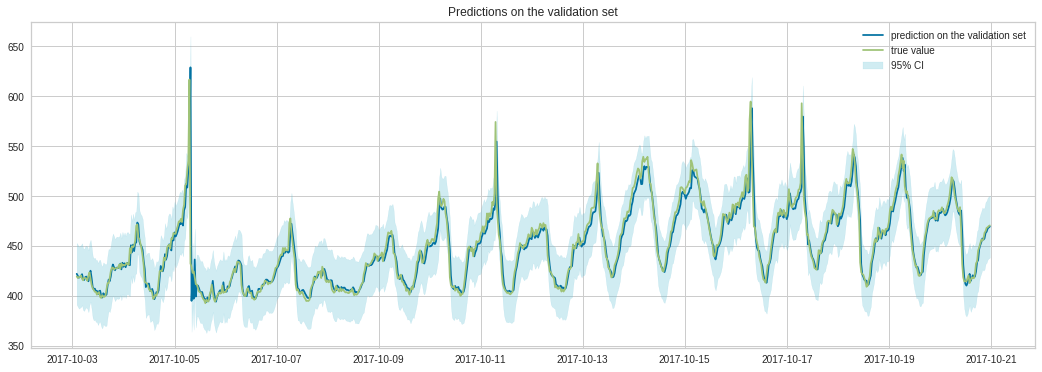

In [47]:
fill_alpha = 0.3
fill_color = '#66C2D7'

fig, ax = plt.subplots(figsize=(18,6))
plt.fill_between(date_pred, lower, upper, color=fill_color, alpha=fill_alpha, label='95% CI')
plt.plot(date_pred, cv_pred, label = 'prediction on the validation set')
plt.plot(date_pred, cv_true_pred, label = 'true value')
plt.title('Predictions on the validation set')
plt.legend()
plt.show()

**We now have all the elements to make our predicitons on the test set after Oct 21**


In [48]:
model = LinearRegression()
model.fit(X, y)

y_train = model.predict(X)

current_last_six = zsbn.loc[X.tail(6).index,'CO2'].values.tolist()
y_test = []

index_testing_data = zsbn.index.to_series().dt.date.between(date(2017,10,21),date(2017,10,31))
X_test = zsbn.loc[index_testing_data].reset_index()

for index,elem in X_test.iterrows():
    inputs = current_last_six[::-1]
    prediction = model.predict([inputs])[0]
    y_test.append(prediction)
    current_last_six.append(prediction)
    current_last_six.pop(0)

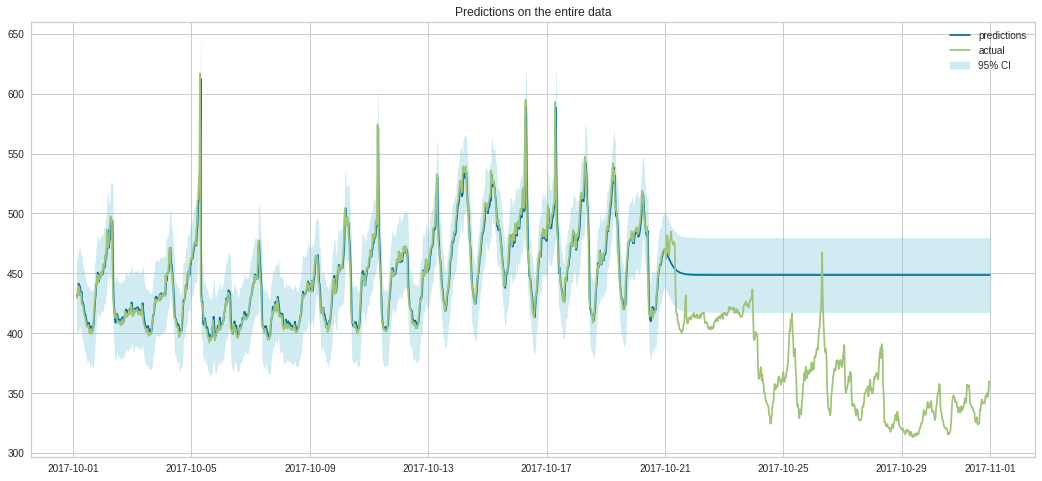

In [49]:
fig, ax = plt.subplots(figsize=(18,8))

train_data = pd.DataFrame(index = zsbn.loc[index_training_data].index , data= {'CO2': y_train})
test_data = pd.DataFrame(index = zsbn.loc[index_testing_data].index , data= {'CO2': y_test})

month_pred = pd.concat([train_data, test_data])

#the CI",
lower = month_pred['CO2'] - margin
upper = month_pred['CO2'] + margin

fill_alpha = 0.3
fill_color = '#66C2D7'

dates = zsbn.reset_index().loc[6::,'timestamp']

plt.plot(month_pred,label = 'predictions')
plt.fill_between(dates, lower, upper, color=fill_color, alpha=fill_alpha, label='95% CI')
plt.plot(zsbn.iloc[6:,-2], label ='actual')

plt.title('Predictions on the entire data')
plt.legend()
plt.show()

**To predict the missing data of the test set we use the last 6 data points of the training set as first inputs and then from that we replace the oldest input by the new prediction. By doing that we obtain as prediction a constant value that is very close to the last value of the training set**

d) **3/35** Train a second forecasting model on the CO2 values of the drifting sensor. In this step, use __current__ values of temperature and humidity as features,  as well as their __past__ values over the same interval of three hours, mathematically, $C_t \sim h(T_{t}, \cdots, T_{t-6}, H_{t}, \cdots, H_{t - 6})$, where $T_i$ and $H_i$ are temperature and humidity at time $i$. Plot and compare the actual CO2 measurements, the values obtained by the prediction of the linear model for the entire month of October, together with their confidence interval obtained from cross validation. Are you able to remove the drift? If yes, how, if no, why?

In [50]:
index_training_data = df_interpolation.index.to_series().dt.date.between(date(2017,10,1),date(2017,10,20))
training_set = zsbn[index_training_data]

# the inputs are the temperature and humidity and the output the C02 measures\n",
X = training_set[['temperature', 'humidity']]
y = training_set["CO2"]
                 
for e in ['temperature','humidity']:
    for i in range(1,7):
        X["lagged_{0}_{1}".format(e,i)] = X[e].shift(i)   # we construct Tt-1,..,Tt-6,Ht,...,Ht-6

#We drop the first six rows because we don't have all the 6 previous points",
X = X[6:]
y = y[6:] 

index_training_data[:6] = False

rmse = []
K = 10
tscv = TimeSeriesSplit(K)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lr = LinearRegression().fit(X_train, y_train)

    y_pred = lr.predict(X_test)
    rmse.append( np.sqrt(2 *mean_squared_error(y_test, y_pred)) )

#compute the CI",
scale = 1.96
mean_rmse = np.mean(rmse)
std_rmse = np.std(rmse)
margin = mean_rmse + scale * std_rmse
margin

70.51667950568694

In [51]:
model = LinearRegression()
model.fit(X, y)

y_train = model.predict(X)

current_last_six = training_set.tail(6)[['temperature','humidity']]
index_testing_data = zsbn.index.to_series().dt.date.between(date(2017,10,21),date(2017,10,31))
X_test = pd.concat([current_last_six, zsbn.loc[index_testing_data, ['temperature','humidity']] ])

for e in ['temperature','humidity']:
    for i in range(1,7):
        X_test["lagged_{0}_{1}".format(e,i)] = X_test[e].shift(i)   # we construct Tt-1,..,Tt-6,Ht,...,Ht-6",

#We drop the first six rows because we don't have all the 6 previous points",
X_test = X_test[6:]
 
y_test = model.predict(X_test)

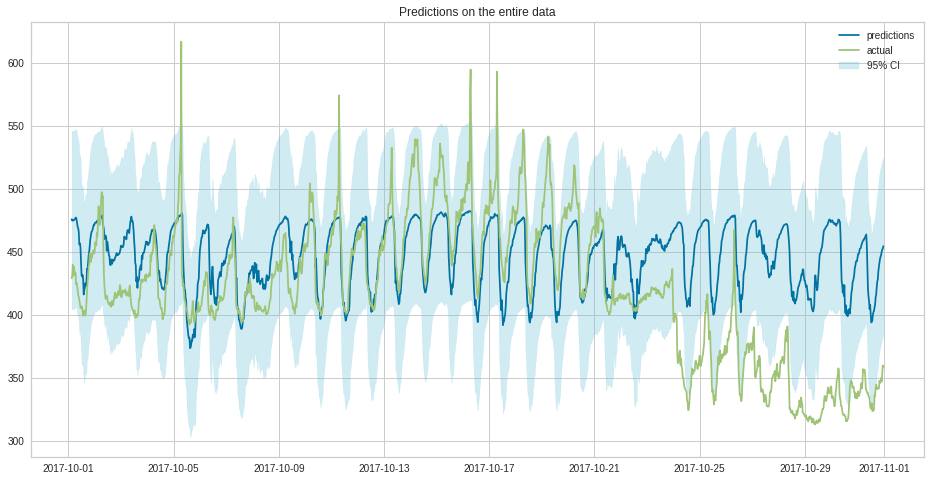

In [52]:
fig, ax = plt.subplots(figsize=(16,8))

train_data = pd.DataFrame(index = X.index , data= {'CO2': y_train})
test_data = pd.DataFrame(index = X_test.index , data= {'CO2': y_test})

month_pred = pd.concat([train_data, test_data])

#the CI",
lower = month_pred['CO2'] - margin
upper = month_pred['CO2'] + margin

fill_alpha = 0.3
fill_color = '#66C2D7'

dates = zsbn.reset_index().loc[6::,'timestamp']

plt.plot(month_pred,label = 'predictions')
plt.fill_between(dates, lower.values, upper.values, color=fill_color, alpha=fill_alpha, label='95% CI')
plt.plot(zsbn.iloc[6:,-2], label ='actual')

plt.title('Predictions on the entire data')
plt.legend()
plt.show()

**We observe that the size of the confidence interval increased due to the increase of the training error but we have a decrease of the error on the test set. Therefore we increased the variance of the model but decreased it's bias. Ass desired we obtain  for the drift part a prediction that it is not drifted but with a smoother shape. We conclude that we succeed in removing the drift but with the small cost of losing some variance of the signal.**

e) **6/35** Build another linear regression model by exploting the fact that the CO2 concentrations, as measured by the sensors __experiencing similar conditions__, are expected to be similar. Apply the learned model to the drifting sensor, and plot the results. Discuss your findings.

Learn a model on other sensors: $ C_t^{S} \sim h(T_{t}^{S}, \cdots, T_{t - 6}^{S}, H_{t}^{S}, \cdots, H_{t - 6}^{S})$, where $S$ is the cluster of sensors experiencing similar conditions like ZSBN.

Apply the model on ZSBN to see if the drift has been removed: $\hat{C}_t^{ZSBN} = h(T_{t}^{ZSBN}, \cdots, T_{t - 6}^{ZSBN}, H_{t}^{ZSBN}, \cdots, H_{t - 6}^{ZSBN})$


**We consider that the sensors *experiencing similar conditions* are the ones in the same `Zone` and `Cluster`.**

In [53]:
zsbn_cluster = zsbn["Cluster"].values[0]

In [54]:
zsbn_sim = final[final['zone'] == zsbn_zone].copy()
zsbn_sim = zsbn_sim[zsbn_sim.Cluster == zsbn_cluster]
zsbn_sim.head()

,temperature,humidity,SensorUnit_ID,LocationName,zone,altitude,LAT,LON,X,Y,CO2,Cluster
timestamp,,,,,,,,,,,,
2017-10-01 00:00:00,11.040000,89.914205,1017,ZHRG,3,410.5,47.377773,8.51946,247999.3,681623.1,425.095878,0.0
2017-10-01 00:30:00,10.960000,89.787048,1017,ZHRG,3,410.5,47.377773,8.51946,247999.3,681623.1,424.306724,0.0
2017-10-01 01:00:00,10.980000,89.294952,1017,ZHRG,3,410.5,47.377773,8.51946,247999.3,681623.1,426.618723,0.0
2017-10-01 01:30:00,10.993333,89.351537,1017,ZHRG,3,410.5,47.377773,8.51946,247999.3,681623.1,430.540983,0.0
2017-10-01 02:00:00,11.033333,89.207850,1017,ZHRG,3,410.5,47.377773,8.51946,247999.3,681623.1,428.007043,0.0


In [55]:
zsbn_sim.LocationName.value_counts()

ZHRG    1488
ZSBN    1488
ZUE     1488
ZHRZ    1488
Name: LocationName, dtype: int64

**There are 4 locations that are experiencing the same conditions as ZSBN. We will apply the model to them.**

In [56]:
# Add the features: temperature and humidity for each one of the locations
features = pd.DataFrame()
features[['ZHRG_temp', 'ZHRG_hum']] = zsbn_sim[zsbn_sim.LocationName == 'ZHRG'][['temperature', 'humidity']].reset_index(drop = True).copy()
features[['ZHRZ_temp', 'ZHRZ_hum']] = zsbn_sim[zsbn_sim.LocationName == 'ZHRZ'][['temperature', 'humidity']].reset_index(drop = True).copy()
features[['ZUE_temp', 'ZUE_hum']] = zsbn_sim[zsbn_sim.LocationName == 'ZUE'][['temperature', 'humidity']].reset_index(drop = True).copy()

features.head()

,ZHRG_temp,ZHRG_hum,ZHRZ_temp,ZHRZ_hum,ZUE_temp,ZUE_hum
0,11.040000,89.914205,10.760000,93.236806,11.026667,90.368154
1,10.960000,89.787048,10.693333,93.650701,10.920000,89.531464
2,10.980000,89.294952,10.593333,93.615097,10.980000,89.072428
3,10.993333,89.351537,10.506667,93.555969,10.986667,89.553080
4,11.033333,89.207850,10.486667,93.871318,10.990000,88.899495


-0.18910376850942767
0.4333000857149806
0.6600941092750523
0.2576509374766742
0.37018649281225824
0.475656617728261
0.4368553112690351
-6.356990242321669
-14.400136374156563
-22.557335948474663


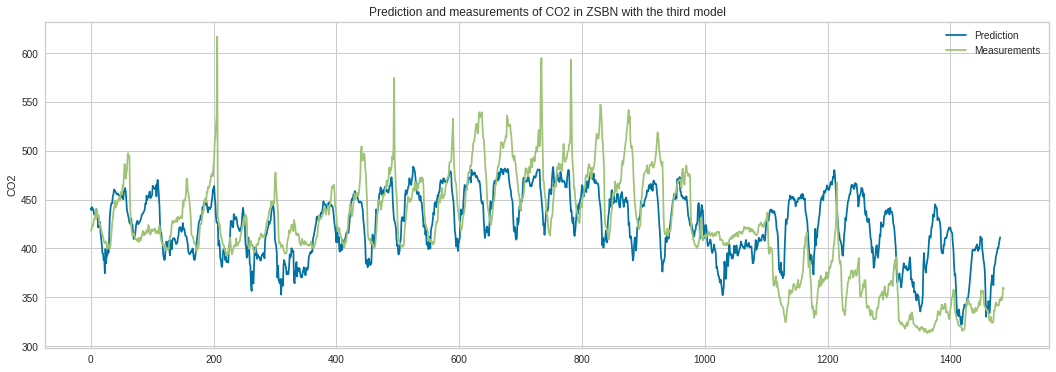

In [57]:
target = zsbn.CO2

for i in range(1,7):
    features["ZHRG_prev_temp_{0}".format(i)] = features.ZHRG_temp.shift(i)
    features["ZHRG_prev_hum_{0}".format(i)] = features.ZHRG_hum.shift(i)
    
    features["ZHRZ_prev_temp_{0}".format(i)] = features.ZHRZ_temp.shift(i)
    features["ZHRZ_prev_hum_{0}".format(i)] = features.ZHRZ_hum.shift(i)
    
    features["ZUE_prev_temp_{0}".format(i)] = features.ZUE_temp.shift(i)
    features["ZUE_prev_hum_{0}".format(i)] = features.ZUE_hum.shift(i)

# After 6th day otherwise there are NaN values
features = features[6:].reset_index(drop=True)
target = target[6:].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(18,6))

for train_index, test_index in tscv.split(features):
    X_train, X_test = features.loc[train_index], features.loc[test_index]
    y_train, y_test = target[train_index], target[test_index]
    lr = LinearRegression().fit(X_train, y_train)
    print(lr.score(X_test, y_test))

plt.plot(lr.predict(features))
plt.plot(zsbn.CO2.reset_index(drop=True))

ax.set_title("Prediction and measurements of CO2 in ZSBN with the third model")
ax.set_ylabel("CO2")
ax.legend(['Prediction', 'Measurements'])
plt.show()

**This model seems to be a very interesting one. Indeed, it does not only fit the measurements accurately but was also able to remove the drift that was observed before. Thus, combining data from locations experiencing similar conditions gives accurate results and is a good way to either verify the consistency of a specific location, or to remove a potentiel drift caused by measurement errors.**

f) **5/35** Redo the question e) with [statsmodels](https://www.statsmodels.org/stable/index.html), a moudle for statistical models with an extensive list of result statistics. Build the linear regression model with statsmodels and examine the result statistics; keep features whose p-value are strictly less than 0.05 and build a new model. Plot and compare the actual CO2 measurements, the values obtained by the prediction of the new model for the entire month of October. Discuss your findings.

__Note__: This introduciton page of [Linear Regression](https://www.statsmodels.org/stable/regression.html) may be helpful to you.

In [58]:
import statsmodels.api as sm

In [59]:
features = sm.add_constant(features, prepend=False)

model = sm.OLS(target, features)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    CO2   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     30.49
Date:                Tue, 07 Apr 2020   Prob (F-statistic):          2.94e-167
Time:                        21:00:22   Log-Likelihood:                -7544.3
No. Observations:                1482   AIC:                         1.517e+04
Df Residuals:                    1439   BIC:                         1.540e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
ZHRG_temp            3.5601      4.901  

**The features whose p-value are strictly less than 0.05 are considered to be statistically significant, so keeping them might give a better model. The p-value can b read in the column P > |t|. Let's now build a new model with these features.**

0.2495077007293924
0.5251325997905952
0.2500288760963335
-0.2728460712148879
-0.4485460976684279
0.01185451195541265
-0.05514282864792097
-5.6494894043905
-12.288378724024337
-25.55700975238938


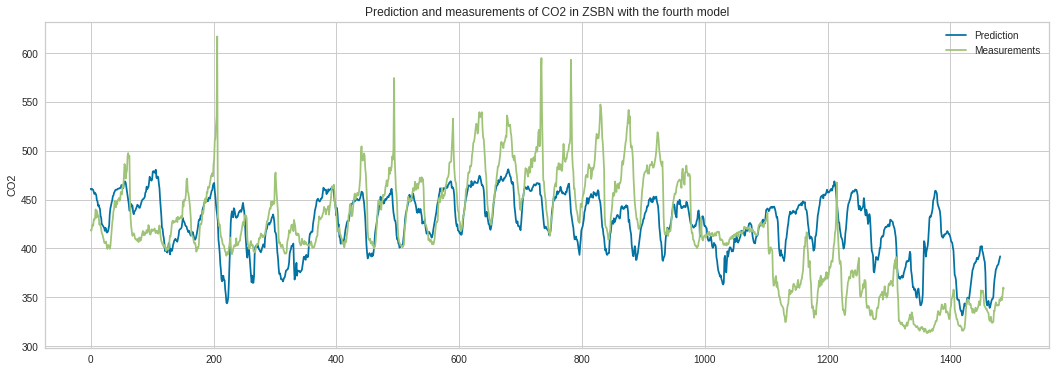

In [60]:
# Keeping only the features with p-value < 0.05
features = features[['ZUE_temp', 'ZUE_hum']]

fig, ax = plt.subplots(figsize=(18,6))

for train_index, test_index in tscv.split(features):
    X_train, X_test = features.loc[train_index], features.loc[test_index]
    y_train, y_test = target[train_index], target[test_index]
    lr = LinearRegression().fit(X_train, y_train)
    print(lr.score(X_test, y_test))

plt.plot(lr.predict(features))
plt.plot(zsbn.CO2.reset_index(drop=True))

ax.set_title("Prediction and measurements of CO2 in ZSBN with the fourth model")
ax.set_ylabel("CO2")
ax.legend(['Prediction', 'Measurements'])
plt.show()

**Even though the prediction seems to have a poorer fit than the previous model (3rd one), the result is still pretty good. Moreover, the drift seems to have been compensated. The interesting thing here is that we only used 2 features instead of 3 locations x 2 parameters x 7 measures = 42 features. Removing 40 of them and still have theses results show that sometimes we don't need that many features to have a satisfying prediction, and we can moreover gain a lot of computation time if we find the most significant features.**

g) **10/35** In this question, we will use __Bayesian Structural Time Serie Modelling__ to reconstruct counterfactual values, that is, what the CO2 measurements of the faulty sensor should have been, had the malfunction not happened on October 21.  We will use the information of provided by similar sensors (the ones you identified in the previous question), together with the covariates associated with the faulty sensors that were not affected by the malfunction (such as temperature and humidity).

To answer this question, you can choose between a Python port of the CausalImpact package (such as https://github.com/dafiti/causalimpact) or the original R version (https://google.github.io/CausalImpact/CausalImpact.html) that you can run in your notebook via an R kernel (https://github.com/IRkernel/IRkernel).

Before you start, watch first the [presentation](https://www.youtube.com/watch?v=GTgZfCltMm8) given by Kay Brodersen (one of the creators of the causal impact implementation in R), and this introductory [ipython notebook](http://nbviewer.jupyter.org/github/dafiti/causalimpact/blob/master/examples/getting_started.ipynb) with examples of how to use the python package.


Is the counterfactual reconstruction of CO2 measurements significantly different from the observed measurements?

In [61]:
x0 = zsbn_sim.loc[zsbn_sim["LocationName"]==zsbn_sim.LocationName.value_counts().index[0],"temperature"]
x1 = zsbn_sim.loc[zsbn_sim["LocationName"]==zsbn_sim.LocationName.value_counts().index[0],"humidity"]
x2 = zsbn_sim.loc[zsbn_sim["LocationName"]==zsbn_sim.LocationName.value_counts().index[1],"temperature"]
x3 = zsbn_sim.loc[zsbn_sim["LocationName"]==zsbn_sim.LocationName.value_counts().index[1],"humidity"]
x4 = zsbn_sim.loc[zsbn_sim["LocationName"]==zsbn_sim.LocationName.value_counts().index[2],"temperature"]
x5 = zsbn_sim.loc[zsbn_sim["LocationName"]==zsbn_sim.LocationName.value_counts().index[2],"humidity"]
x6 = zsbn_sim.loc[zsbn_sim["LocationName"]==zsbn_sim.LocationName.value_counts().index[3],"temperature"]
x7 = zsbn_sim.loc[zsbn_sim["LocationName"]==zsbn_sim.LocationName.value_counts().index[3],"humidity"]
y = zsbn_sim.loc[zsbn_sim["LocationName"]=="ZSBN","CO2"]
    
data = pd.DataFrame({'x0': x0, 'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'x5': x5,'x6': x6, 'x7': x7 ,'y': y}, columns=['y', 'x0', 'x1', 'x2', 'x3','x4', 'x5','x6','x7'])
index_pre = zsbn_sim[zsbn_sim.index <= "2017-10-21"].index.to_list()
index_post = zsbn_sim[zsbn_sim.index > "2017-10-21"].index.to_list()
index_pre = [ index_pre[0], index_pre[-1] ]  
index_post = [ index_post[0], index_post[-1] ]

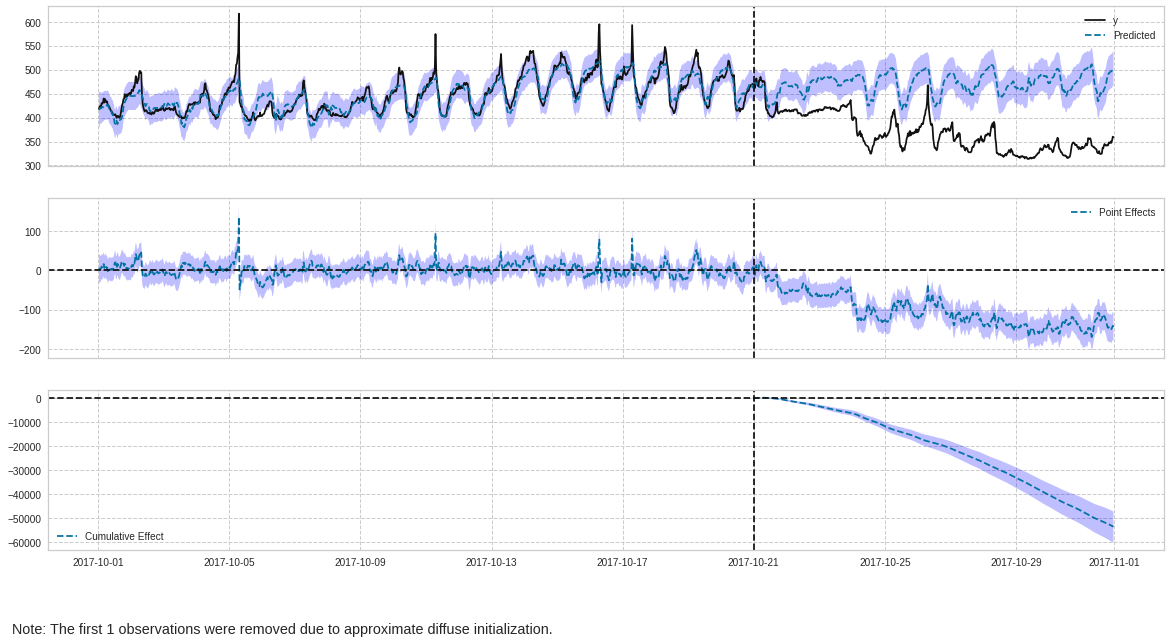

In [62]:
from causalimpact import CausalImpact

ci = CausalImpact(data,index_pre, index_post)
ci.plot(figsize=(20, 10))

**Here we observe a higher differences between the prediction and the actual measurements. Two things needs also to be note: The predicted seems to have a better fit before October 21th which is a good indicator of a good fit. Also we see around the drifting period that we don't have an inverted pic anymore which seems more coherent.**

h) **Bonus (5):** Remove the drift with an advanced machine learning model of your choice. Discuss the results. 

In [63]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
 
# define input sequence
zsbn_train=zsbn[:"2017-10-20"].copy()
in_seq1 = zsbn_train.temperature.values
in_seq2 = zsbn_train.humidity.values
out_seq = zsbn_train.CO2.values

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

# choose a number of time steps
n_steps_in, n_steps_out = 6,1

# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

n_features = X.shape[2]

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=300, verbose=0)

# Run the prediction
zsbn_to_predict=zsbn.reset_index().copy()
#zsbn_to_predict=zsbn_to_predict[954:]
temp_predict=zsbn_to_predict.temperature.values
hum_predict=zsbn_to_predict.humidity.values

x_input = np.c_[temp_predict,hum_predict]
predictions=[]
for i in range(x_input.shape[0]-n_steps_in):
    x_i=x_input[i:i+n_steps_in]
    x_i = x_i.reshape((1, n_steps_in, n_features))
    predictions.append(model.predict(x_i, verbose=0)[0][0])

Using TensorFlow backend.


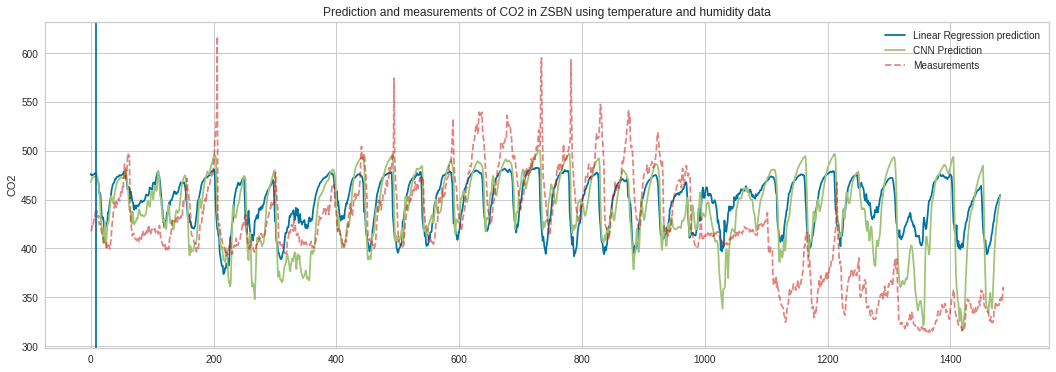

In [64]:
fig ,ax = plt.subplots(figsize=(18,6))
plt.plot(month_pred.CO2.values)
plt.plot(predictions)
plt.plot(zsbn.CO2.values, "r--",alpha=0.5)
plt.axvline(x=9)
ax.set_title("Prediction and measurements of CO2 in ZSBN using temperature and humidity data")
ax.set_ylabel("CO2")
ax.legend(['Linear Regression prediction','CNN Prediction', 'Measurements'])
plt.show()

**Comparing the prediction with the CNN model to the linear regression model with the same input, We see from the plot that the CNN model fits the data better before the drift, but it seems to have a higher variance after the drift, so the linear regression might be the better choice to fix the drift.**